In [1]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import GridSearchCV, StratifiedKFold 
from sklearn.metrics import f1_score 
from sklearn.calibration import calibration_curve, CalibratedClassifierCV, FrozenEstimator 
import optuna 
import xgboost as xgb 
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader, TensorDataset 
import torch.nn.functional as F
import joblib 
import random


import warnings
warnings.filterwarnings('ignore')

/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Загрузка данных

Загружаем предобработанные на этапе EDA датасеты для трейна и для теста

In [2]:
# Данные для обучения берутся из аугментированного датасета, в котором бойцы поменяны местами
data_train = pd.read_csv('data_preprocessed/data_final_6596.csv', index_col='Unnamed: 0')
# Данные для тестирования берутся из датасета без аугментации
data_test = pd.read_csv('data_preprocessed/data_test_final_3298.csv', index_col='Unnamed: 0')

Создаем обучающую и тестовую выборки. Поскольку более ранние бои могут нести в себе информацию, влияющую на результат более поздних боев, для теста будем брать самые последние бои во избежание утечки данных

In [3]:
# Определим количество боев, используемое для обучения и оценки моделей
train_edge = int(len(data_train) * 0.25)
test_edge = int(len(data_test) * 0.25) 

# Данные для трейна берем из аугментированного датасета, выделяя из него три четверти
X_train = data_train.drop(columns=['Result', 'RedFighter', 'BlueFighter'], axis=1).iloc[train_edge:, :]
y_train = data_train['Result'].iloc[train_edge:]

# Данные для теста берем из не аугментированного датасета, выделяя из него одну четверть
X_test = data_test.drop(columns=['Result', 'RedFighter', 'BlueFighter'], axis=1).iloc[:test_edge, :]
y_test = data_test['Result'].iloc[:test_edge]

In [4]:
data_test.drop(columns=['Result', 'RedFighter', 'BlueFighter'], axis=1).iloc[:test_edge, :]

,RedStance,BlueStance,RedOdds,BlueOdds,Age_diff,Height_diff,Reach_diff,Weight_diff,WinsByKO/TKO_diff,WinsBySubmission_diff,...,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,LongestWinStreak_diff,TotalRoundsFought_diff,TimeSinceLastFight_diff,Rank_diff,Curr_streak_diff
1,0.0,0.0,-210.0,295.0,3,-5.08,7.62,0,-2,5,...,-1.38,0.06,0.72,-0.26,1.5,-2,-9,196,4.0,-2
2,0.0,0.0,-380.0,300.0,-2,-7.62,2.54,-5,-2,1,...,0.36,0.03,0.13,-0.42,0.3,3,-11,294,1.0,-3
3,1.0,1.0,-950.0,625.0,-6,2.54,0.00,0,0,0,...,-1.44,0.14,2.98,0.16,1.1,5,15,-224,3.0,1
4,0.0,0.0,-130.0,110.0,3,-2.54,5.08,0,-3,2,...,1.84,-0.07,0.25,0.04,0.2,0,2,112,0.0,0
5,1.0,0.0,-380.0,300.0,-2,0.00,2.54,0,-3,-5,...,1.63,0.01,-0.11,0.02,-0.3,3,-42,21,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,1.0,0.0,-180.0,155.0,3,-2.54,10.16,0,1,1,...,0.41,0.13,-0.11,-0.15,0.1,2,7,63,0.0,3
1118,0.0,0.0,-195.0,165.0,-5,-10.16,-17.78,-10,2,-5,...,-1.24,-0.03,0.29,-0.11,-1.6,1,2,308,0.0,0
1119,1.0,1.0,-140.0,120.0,-3,-5.08,-2.54,0,2,0,...,0.12,-0.04,-0.07,0.22,0.3,3,4,301,0.0,2
1120,1.0,0.0,-125.0,105.0,7,-2.54,5.08,0,0,-4,...,-1.00,-0.11,-0.41,-0.08,-1.3,1,24,42,0.0,0


Масштабируем числовые признаки. Категориальных признаков у нас нет.

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Экспорт скейлера

In [6]:
# joblib.dump(scaler, 'models/ufc_stand_scaler.joblib')

In [6]:
data_test

,RedFighter,BlueFighter,RedStance,BlueStance,RedOdds,BlueOdds,Result,Age_diff,Height_diff,Reach_diff,...,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,LongestWinStreak_diff,TotalRoundsFought_diff,TimeSinceLastFight_diff,Rank_diff,Curr_streak_diff
1,Shavkat Rakhmonov,Ian Machado Garry,0.0,0.0,-210.0,295.0,0,3,-5.08,7.62,...,-1.38,0.060,0.7200,-0.260,1.5000,-2,-9,196,4.0,-2
2,Ciryl Gane,Alexander Volkov,0.0,0.0,-380.0,300.0,0,-2,-7.62,2.54,...,0.36,0.030,0.1300,-0.420,0.3000,3,-11,294,1.0,-3
3,Bryce Mitchell,Kron Gracie,1.0,1.0,-950.0,625.0,0,-6,2.54,0.00,...,-1.44,0.140,2.9800,0.160,1.1000,5,15,-224,3.0,1
4,Nate Landwehr,Dooho Choi,0.0,0.0,-130.0,110.0,1,3,-2.54,5.08,...,1.84,-0.070,0.2500,0.040,0.2000,0,2,112,0.0,0
5,Dominick Reyes,Anthony Smith,1.0,0.0,-380.0,300.0,0,-2,0.00,2.54,...,1.63,0.010,-0.1100,0.020,-0.3000,3,-42,21,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,Frank Mir,Shane Carwin,1.0,0.0,-150.0,140.0,1,-5,2.54,-2.54,...,3.00,0.083,0.4667,0.184,1.2667,1,17,0,0.0,-2
6512,Nate Diaz,Rory Markham,1.0,0.0,-235.0,195.0,0,-4,0.00,12.70,...,0.57,0.134,1.3333,0.476,1.4444,4,18,0,0.0,0
6518,Junior Dos Santos,Gabriel Gonzaga,0.0,0.0,-250.0,230.0,0,-4,5.08,2.54,...,-9.04,-0.010,-1.2000,-0.572,-0.7000,0,-10,0,0.0,3
6521,Clay Guida,Shannon Gugerty,0.0,0.0,-420.0,335.0,0,0,-7.62,-2.54,...,-8.18,0.061,2.1500,-0.281,-0.6500,2,19,0,0.0,-1


### Подготовка к обучению моделей

Создадим словарь, в который будем добавлять построенные модели

In [7]:
models = {}

Напишем функции для вывода результатов

In [8]:
def display_results(y_test: pd.Series, y_pred: np.array) -> None:
    """
    Выводит Classification Report и матрицу ошибок для выбранных предсказаний
    """
    # Выводим метрики качества модели
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Матрица ошибок
    sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
    plt.ylabel('Real value')
    plt.xlabel('predicted value')

In [9]:
def plot_confidence(y_test: pd.Series, y_proba: np.array, model: any=None) -> None:
    """
    Строит график уверенности класификатора относительно сделанных предсказаний
    Отображает на графике уверенность идеального классификатора 
    """
    # Калибровочная кривая
    y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
    prob_true, prob_pred = calibration_curve(y_test, y_proba_positive, n_bins=10, strategy="uniform")
    
    # Построение графика
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Калибровочная кривая')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
    plt.xlabel('Предсказанная вероятность')
    plt.ylabel('Эмпирическая вероятность')
    plt.title(f'График уверенности классификатора')
    plt.legend()

In [10]:
def prob_calibration(X_test: np.array, y_test: np.array, model: any, use_frozen:bool=False) -> dict:
    """
    Калибрует вероятности предсказаний классификатора при помощи изотонической регрессии
    Возвращает словарь:
    model: откалиброванная модель
    proba: вероятности предсказаний откалиброванной модели
    """
   
    if not use_frozen:
        calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
    else:
        calibrated_model = CalibratedClassifierCV(FrozenEstimator(model), method='isotonic', cv='prefit')
        
    calibrated_model.fit(X_test, y_test)
    # Предсказанные вероятности после калибровки
    calibrated_proba = calibrated_model.predict_proba(X_test)
    y_pred_calibrated = calibrated_model.predict(X_test)
    # Выводим метрики качества модели
    print("Classification Report:")
    print(classification_report(y_test, y_pred_calibrated))

    # График вероятностей
    plt.hist(calibrated_proba[:, 1], alpha=0.5, label='Класс 1 (боец в синем)')
    plt.hist(calibrated_proba[:, 0], alpha=0.5, label='Класс 0 (боец в красном)')    
    plt.xlabel('Вероятность')
    plt.ylabel('Частота')
    plt.title('График вероятностей')
    plt.legend()
    plt.show()

    return {'model': calibrated_model, 'proba': calibrated_proba}

Введем свою бизнес-метрику, равную относительному приросту (в %) суммарного выигрыша, который можно получить, поставив на исход каждого боя в соответствии с предсказанием модели по срввнению с выигрышем при ставке исключительно на фаворитов каждого боя, определяемых букмекерами. 

Сумму выигрыша будем рассчитывать исходя из реальных коэффициентов на каждого бойца, определяемых букмекерами. В датасете есть соответствующие признаки `RedOdds` и `BlueOdds`

In [11]:
def calc_odds(row: pd.Series) -> pd.Series:
    """
    Пересчет коэффициентов букмекеров
    из американского в европейский (десятичный) формат
    """
    for col in ['RedOdds', 'BlueOdds']:
        if row[col] > 0:
            row[col] = row[col] / 100 + 1
        else:
            row[col] = 100 / np.abs(row[col]) + 1
    return row

def calc_model_gain(row: pd.Series, bet_size: int = 1000) -> int:
    """
    Расчет выигрыша, полученного при ставке на бой,
    сделанной на основании предсказаний модели
    """
    if row['PredError'] == 0:
        return int((row['RedOdds'], row['BlueOdds'])[row['ActualWinner']] * bet_size)
    else:
        return - bet_size
    
def calc_odds_gain(row: pd.Series, bet_size: int = 1000) -> int:
    """
    Расчет выигрыша, полученного при ставке на бой,
    сделанной на основании коэффициентов букмекеров
    """
    if row['ActualWinner'] == 0 and row['RedOdds'] < row['BlueOdds']:
        return int(row['RedOdds'] * bet_size)
    elif row['ActualWinner'] == 1 and row['RedOdds'] > row['BlueOdds']:
        return int(row['BlueOdds'] * bet_size)
    else:
        return - bet_size


def calc_guess_gain(row: pd.Series, bet_size: int = 1000) -> int:
    """
    Расчет выигрыша, полученного при ставке на бой,
    сделанной на основании случайного угадывания
    """
    odds = (row['RedOdds'], row['BlueOdds'])
    odds_number = (0, 1)
    chosen_odd = random.choice(odds_number)  
    if chosen_odd == row['ActualWinner']:
        return int(odds[chosen_odd] * bet_size)
    else:
        return - bet_size

Для наглядного представления результатов создадим датафрейм, куда будут собраны:
- результаты всех боев;
- результаты предсказаний модели;
- ошибки предсказаний модели;
- коэффициенты букмекеро на каждого бойца 

In [12]:
def display_business_metrics(y_proba: np.array) -> pd.DataFrame:
    """
    Возвращает датафрейм с предсказаниями победителя боя и
    предсказанными вероятностями победы каждого из бойцов.
    Также возвращает значение прироста выигрыша при исользовании модели
    """

    # Создание датафрейма для хранения результатов
    results_df = pd.DataFrame({
                                'RedFighter': data_test['RedFighter'].iloc[:test_edge],
                                'BlueFighter': data_test['BlueFighter'].iloc[:test_edge],
                                'RedOdds': data_test['RedOdds'].iloc[:test_edge],
                                'BlueOdds': data_test['BlueOdds'].iloc[:test_edge],
                                'ProbRedWins': y_proba [:, 0],
                                'ProbBlueWins': y_proba [:, 1],
                                'ActualWinner': data_test['Result'].iloc[:test_edge]
                              })
    # Создаем дополнительные столбцы
    results_df['PredWinner'] = (results_df['ProbBlueWins'] > results_df['ProbRedWins']).astype(int)
    results_df['PredError'] = np.abs(results_df['PredWinner'] - results_df['ActualWinner'])
    results_df.iloc[:, :]

    # Рассчитывем сумму выигрыша
    results_df = results_df.apply(calc_odds, axis=1)
    # Ставки на основании прогнозов модели
    results_df['GainModel'] = results_df.apply(calc_model_gain, axis=1) 
    # Ставки на фаворита букмекеров в каждом бою
    results_df['GainOdds'] = results_df.apply(calc_odds_gain, axis=1) 
    # Ставки, сделанные случайным образом
    results_df['GainGuess'] = results_df.apply(calc_guess_gain, axis=1) 
    # Относительный прирост выигрыша
    relative_gain = (results_df['GainModel'].sum() - results_df['GainOdds'].sum()) / results_df['GainOdds'].sum() * 100

    # Выводим результаты на печать
    print(f'Результат выигрыша при использовании модели: {results_df['GainModel'].sum()} рублей')
    print(f'Результат выигрыша при использовании ставок: {results_df['GainOdds'].sum()} рублей')
    print(f'Результат выигрыша при случайном угадывании: {results_df['GainGuess'].sum()} рублей')  
    print('-' * 60)  
    print(f'Относительный прирост выигрыша при использовании модели: {relative_gain:.1f} %')
    return results_df

### 1. Логистическая регрессия

In [673]:
params = {'penalty': [None, 'l1', 'l2'],
          'C': np.linspace(0.001, 10000, 24),
          'solver': ['liblinear', 'newton-cs'],
          'class_weight': [None],
          'fit_intercept': [True, False]}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

gs_logreg = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=params, cv=folds, scoring='f1', verbose=True, n_jobs=-1)

# Обучаем модель на тренировочных данных
gs_logreg.fit(X_train, y_train)

# Делаем прогнозы на тестовых данных
y_pred = gs_logreg.predict(X_test)
y_proba = gs_logreg.predict_proba(X_test)

# Добавляем обученную модель и ее предсказания в словарь
models['logreg'] = {'model': gs_logreg.best_estimator_, 'y_pred': y_pred, 'y_proba': y_proba}

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       465
           1       0.66      0.61      0.64       359

    accuracy                           0.69       824
   macro avg       0.69      0.68      0.69       824
weighted avg       0.69      0.69      0.69       824



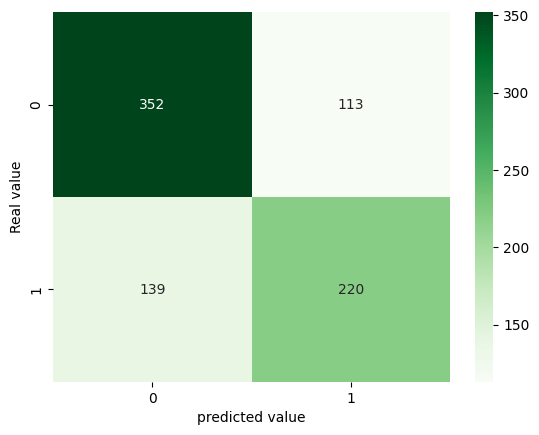

In [674]:
display_results(y_test, models['logreg']['y_pred'])

Построим график уверенности классификатора относительно сделанных прогнозов

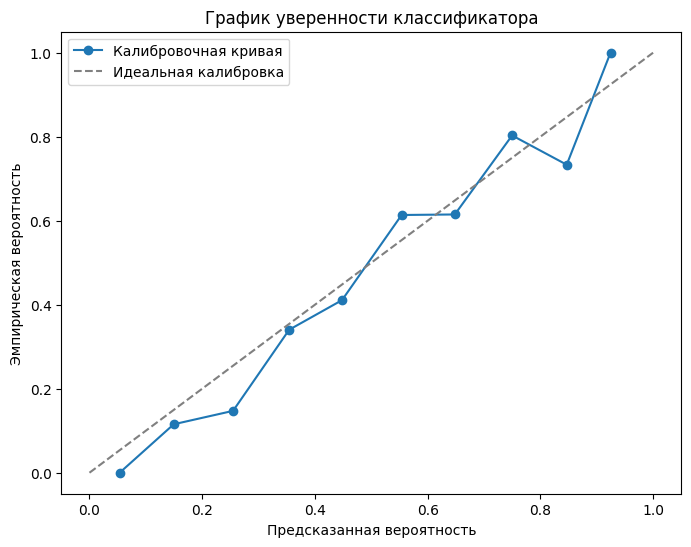

In [675]:
plot_confidence(y_test, models['logreg']['y_proba'], models['logreg']['model'])

Откалибруем уверенность классификатора при помощи изотонической регрессии 

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       465
           1       0.68      0.60      0.64       359

    accuracy                           0.70       824
   macro avg       0.70      0.69      0.69       824
weighted avg       0.70      0.70      0.70       824



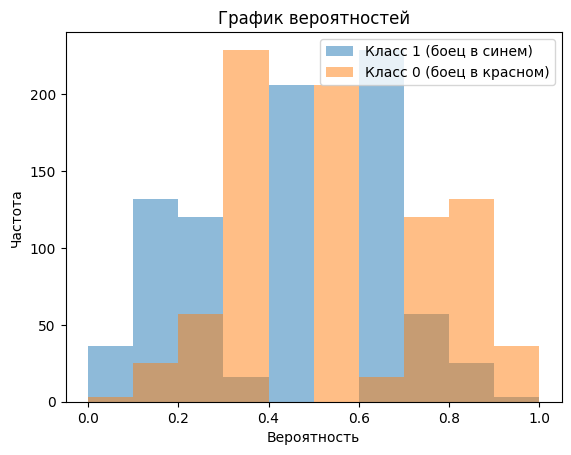

In [676]:
logreg_calibrated = prob_calibration(X_test, y_test, models['logreg']['model'])

In [677]:
display_business_metrics(logreg_calibrated['proba'])

Результат выигрыша при использовании модели: 611558 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при случайном угадывании: 355398 рублей
------------------------------------------------------------
Относительный прирост выигрыша при использовании модели: 3.8 %


,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,PredWinner,PredError,GainModel,GainOdds,GainGuess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.850746,0.149254,0,0,0,1476,1476,1476
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.850746,0.149254,0,0,0,1263,1263,-1000
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,1.000000,0.000000,0,0,0,1105,1105,1105
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.586207,0.413793,1,0,1,-1000,-1000,2100
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.716667,0.283333,0,0,0,1263,1263,-1000
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.692308,0.307692,1,0,1,-1000,-1000,2550
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.586207,0.413793,0,0,0,1512,1512,1512
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.586207,0.413793,0,0,0,1714,1714,1714
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.586207,0.413793,1,0,1,-1000,-1000,-1000


### 2. XGBoost

In [33]:
def objective(trial):
    # Определение гиперпараметров для оптимизации
    max_depth = trial.suggest_int('max_depth', 1, 16)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    gamma = trial.suggest_loguniform('gamma', 0.01, 10.0)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.2, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 0.01, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 0.01, 10.0)

    # Создание модели
    model = xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,
                              n_estimators=n_estimators, gamma=gamma,
                              subsample=subsample, colsample_bytree=colsample_bytree,
                              reg_alpha=reg_alpha, reg_lambda=reg_lambda)

    # Обучение модели
    model.fit(X_train, y_train)

    # Оценка модели
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    return f1

# Создание Bayesian Optimization
study = optuna.create_study(direction='maximize')

# Запуск Bayesian Optimization
study.optimize(objective, n_trials=200)

# Создание модели с лучшими гиперпараметрами
best_model = xgb.XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# Оценка модели с лучшими гиперпараметрами
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

models['XGBoost'] = {'model': best_model, 'y_pred': y_pred, 'y_proba':y_proba}

[I 2025-01-24 23:28:36,838] A new study created in memory with name: no-name-c79f6ae9-20ba-473b-92bb-ed988b476832
[I 2025-01-24 23:28:37,011] Trial 0 finished with value: 0.6556473829201102 and parameters: {'max_depth': 11, 'learning_rate': 0.015223693762966098, 'n_estimators': 41, 'gamma': 0.15752332153111287, 'subsample': 0.7638738448070523, 'colsample_bytree': 0.8081957557881763, 'reg_alpha': 3.4672000685796167, 'reg_lambda': 0.12100049630319436}. Best is trial 0 with value: 0.6556473829201102.
[I 2025-01-24 23:28:37,171] Trial 1 finished with value: 0.6340782122905028 and parameters: {'max_depth': 12, 'learning_rate': 0.025775042389061413, 'n_estimators': 68, 'gamma': 0.8240557753840475, 'subsample': 0.7414001707154205, 'colsample_bytree': 0.3195664719128328, 'reg_alpha': 2.4628558064151544, 'reg_lambda': 0.10429497230120617}. Best is trial 0 with value: 0.6556473829201102.
[I 2025-01-24 23:28:37,283] Trial 2 finished with value: 0.6068027210884354 and parameters: {'max_depth': 14,

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75       465
           1       0.67      0.69      0.68       359

    accuracy                           0.72       824
   macro avg       0.71      0.71      0.71       824
weighted avg       0.72      0.72      0.72       824



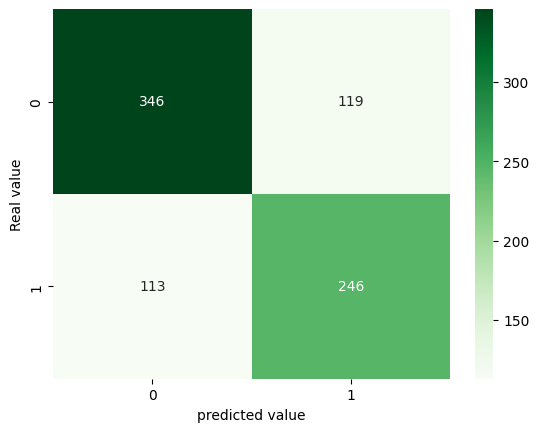

In [34]:
display_results(y_test, models['XGBoost']['y_pred'])

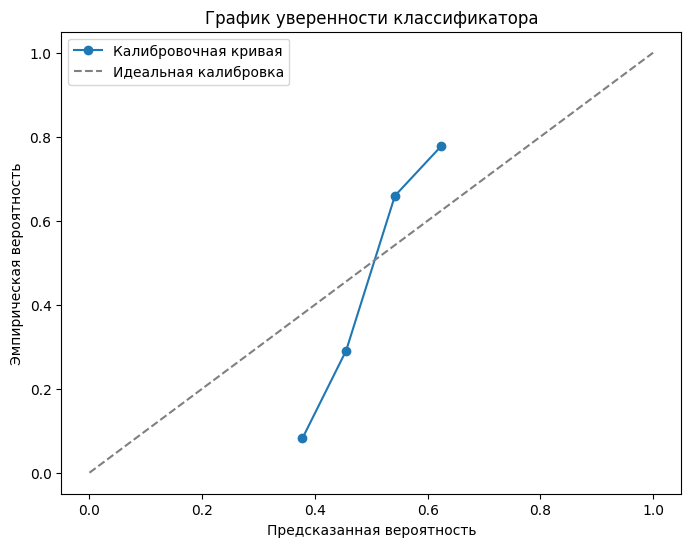

In [35]:
plot_confidence(y_test, models['XGBoost']['y_proba'], models['XGBoost']['model'])

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       465
           1       0.68      0.68      0.68       359

    accuracy                           0.72       824
   macro avg       0.71      0.71      0.71       824
weighted avg       0.72      0.72      0.72       824



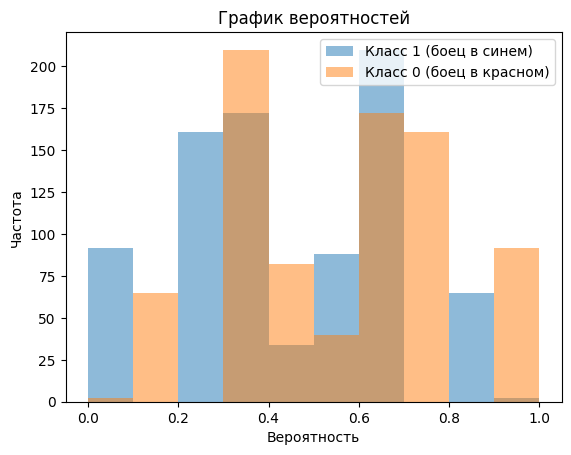

In [36]:
xgboost_calibrated = prob_calibration(X_test, y_test, models['XGBoost']['model'], use_frozen=True)

In [37]:
# display_business_metrics(y_proba)
display_business_metrics(xgboost_calibrated['proba'])

Результат выигрыша при использовании модели: 661686 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при случайном угадывании: 330371 рублей
------------------------------------------------------------
Относительный прирост выигрыша при использовании модели: 12.3 %


,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,PredWinner,PredError,GainModel,GainOdds,GainGuess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.724138,0.275862,0,0,0,1476,1476,1476
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.933333,0.066667,0,0,0,1263,1263,-1000
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,1.000000,0.000000,0,0,0,1105,1105,1105
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.666667,0.333333,1,0,1,-1000,-1000,-1000
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.933333,0.066667,0,0,0,1263,1263,1263
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.682119,0.317881,1,0,1,-1000,-1000,-1000
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.500000,0.500000,0,0,0,1512,1512,1512
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.724138,0.275862,0,0,0,1714,1714,-1000
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.682119,0.317881,1,0,1,-1000,-1000,2050


Экспорт модели

In [28]:
# joblib.dump(xgboost_calibrated['model'], 'models/xgboost_model.joblib')

['models/xgboost_model.joblib']

### 3. Нейронная сеть 

In [38]:
# Определяем класс датасета
class FighterDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# Создаем датасеты и даталоадеры для трейновой и тестовой частей
train_dataset = FighterDataset(X_train, y_train)
test_dataset = FighterDataset(X_test, y_test)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [39]:
# Определяем класс нейронной сети
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(22, 128)  # входной слой
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 128)  # скрытый слой
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(128, 64)  
        self.dropout3 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(64, 64)  
        self.dropout4 = nn.Dropout(p=0.2)
        self.fc5 = nn.Linear(64, 32)  
        self.dropout5 = nn.Dropout(p=0.2)
        self.fc6 = nn.Linear(32, 2)  # выходной слой   

    def forward(self, x):        
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))  
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))  
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))  
        x = self.dropout4(x)
        x = torch.relu(self.fc5(x))  
        x = self.dropout5(x)
        x = self.fc6(x)
        return x

In [126]:
# Инициализируем нейронную сеть, выбираем функцию потерь и оптимизатор
net = FighterNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)

# Обучение нейронной сети
for epoch in range(60):
    for batch in train_dataloader:
        x, y = batch  
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y.long()) 
        loss.backward()
        optimizer.step()
    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

Эпоха 1, потеря: 0.6970794200897217
Эпоха 2, потеря: 0.6875796318054199
Эпоха 3, потеря: 0.6951841115951538
Эпоха 4, потеря: 0.6968643069267273
Эпоха 5, потеря: 0.688791811466217
Эпоха 6, потеря: 0.6902461051940918
Эпоха 7, потеря: 0.7008252143859863
Эпоха 8, потеря: 0.6959922313690186
Эпоха 9, потеря: 0.6914635896682739
Эпоха 10, потеря: 0.6875253915786743
Эпоха 11, потеря: 0.6909210085868835
Эпоха 12, потеря: 0.6886205077171326
Эпоха 13, потеря: 0.682600200176239
Эпоха 14, потеря: 0.678347647190094
Эпоха 15, потеря: 0.6760294437408447
Эпоха 16, потеря: 0.6695835590362549
Эпоха 17, потеря: 0.6649667024612427
Эпоха 18, потеря: 0.6883386969566345
Эпоха 19, потеря: 0.6624086499214172
Эпоха 20, потеря: 0.7032127976417542
Эпоха 21, потеря: 0.7006144523620605
Эпоха 22, потеря: 0.6618990898132324
Эпоха 23, потеря: 0.6917163133621216
Эпоха 24, потеря: 0.6703693270683289
Эпоха 25, потеря: 0.669731080532074
Эпоха 26, потеря: 0.6154731512069702
Эпоха 27, потеря: 0.659197986125946
Эпоха 28, потер

In [127]:
# Оценка модели на тестовых данных
net.eval()
y_proba = []
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        x, y = batch 
        outputs = net(x)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_pred_proba = torch.nn.functional.softmax(outputs, dim=1)
        y_proba.extend(y_pred_proba.numpy())
        y_true.extend(y.cpu().numpy())

print(f'f1_score: {f1_score(y_true, y_pred, average='weighted'):.3f}')
y_proba = np.array(y_proba)

models['NN'] = {'model': net, 'y_pred': y_pred, 'y_proba': y_proba}

f1_score: 0.700


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       465
           1       0.66      0.65      0.65       359

    accuracy                           0.70       824
   macro avg       0.70      0.69      0.69       824
weighted avg       0.70      0.70      0.70       824



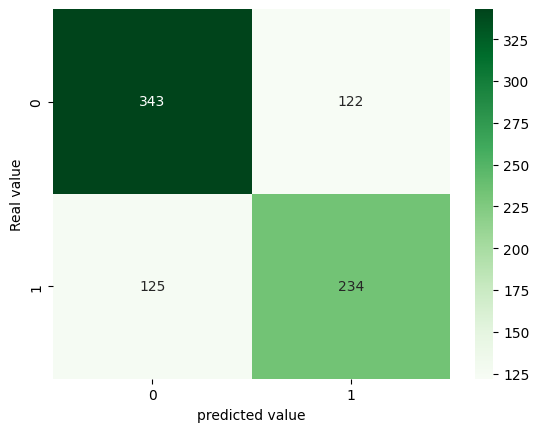

In [128]:
display_results(y_test, models['NN']['y_pred'])

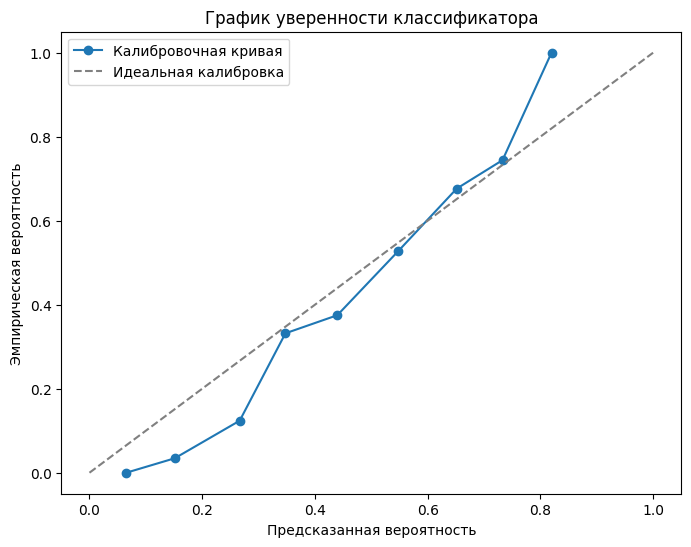

In [129]:
plot_confidence(y_test, models['NN']['y_proba'])

У меня не получилось откалибровать вероятности нейросети ни изотонической регрессией, ни другими способами, но как видно из графика калибровки, она, фактически и не нуждается в калибровке, т.к. вероятности отнесения объектов в разным классам у нее близки к идеальным

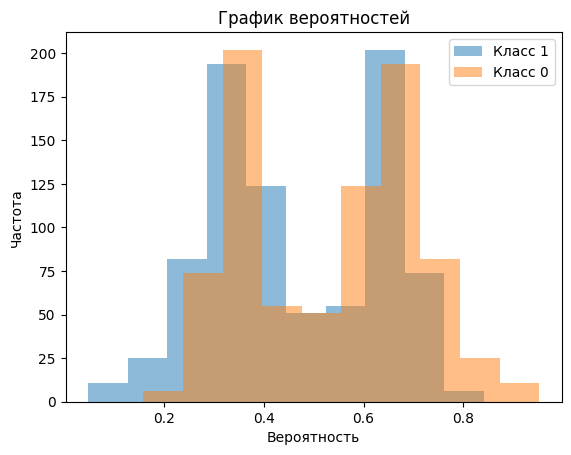

In [130]:
y_proba = models['NN']['y_proba']
plt.hist(y_proba[:, 1], alpha=0.5, label='Класс 1')
plt.hist(y_proba[:, 0], alpha=0.5, label='Класс 0')
plt.xlabel('Вероятность')
plt.ylabel('Частота')
plt.title('График вероятностей')
plt.legend()
plt.show()

In [131]:
display_business_metrics(models['NN']['y_proba'])

Результат выигрыша при использовании модели: 603198 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при случайном угадывании: 302729 рублей
------------------------------------------------------------
Относительный прирост выигрыша при использовании модели: 2.3 %


,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,PredWinner,PredError,GainModel,GainOdds,GainGuess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.661016,0.338984,0,0,0,1476,1476,1476
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.673449,0.326551,0,0,0,1263,1263,-1000
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,0.861636,0.138364,0,0,0,1105,1105,1105
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.583294,0.416706,1,0,1,-1000,-1000,2100
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.727245,0.272755,0,0,0,1263,1263,1263
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.674473,0.325527,1,0,1,-1000,-1000,2550
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.618996,0.381004,0,0,0,1512,1512,1512
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.648962,0.351038,0,0,0,1714,1714,1714
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.606835,0.393165,1,0,1,-1000,-1000,-1000


### 4. RNN

In [132]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 1, x.size(1))
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return torch.sigmoid(out)

In [322]:
model = RNNModel(input_dim=X_train.shape[1], hidden_dim=64, output_dim=1)

# Обучение модели
criterion = nn.BCELoss()
optimizer = optim.Rprop(model.parameters(), lr=0.01)

for epoch in range(20):
    for batch in train_dataloader:
        inputs, labels = batch
        inputs = inputs.float()  
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.5907325148582458
Epoch 2, Loss: 0.6970428824424744
Epoch 3, Loss: 0.6494064927101135
Epoch 4, Loss: 0.648760974407196
Epoch 5, Loss: 0.5842489004135132
Epoch 6, Loss: 0.590178906917572
Epoch 7, Loss: 0.5230888724327087
Epoch 8, Loss: 0.6398879885673523
Epoch 9, Loss: 0.6594348549842834
Epoch 10, Loss: 0.7781978249549866
Epoch 11, Loss: 0.6466896533966064
Epoch 12, Loss: 0.5447195768356323
Epoch 13, Loss: 0.6563448905944824
Epoch 14, Loss: 0.6793891787528992
Epoch 15, Loss: 0.6186254620552063
Epoch 16, Loss: 0.6111990809440613
Epoch 17, Loss: 0.5589407086372375
Epoch 18, Loss: 0.6416881084442139
Epoch 19, Loss: 0.5771212577819824
Epoch 20, Loss: 0.5468208193778992


In [323]:
# Оценка модели
model.eval()
with torch.no_grad():
    total_correct = 0
    predicted_labels = []
    test_labels = []
    predicted_probas = []
    for batch in test_dataloader:
        inputs, labels = batch
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        predicted_labels.extend(predicted.numpy().flatten())
        test_labels.extend(labels.numpy().flatten())
        predicted_probas.extend(outputs.numpy().flatten())        

# Преобразовываем списки в numpy массивы
y_pred = np.array(predicted_labels)
y_proba_1 = np.array(predicted_probas)
y_proba_0 = 1 - np.array(predicted_probas)
y_proba = np.stack((y_proba_0, y_proba_1), axis=1)

models['RNN'] = {'model': model, 'y_pred': y_pred, 'y_proba': y_proba}

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       465
           1       0.67      0.64      0.65       359

    accuracy                           0.70       824
   macro avg       0.70      0.69      0.70       824
weighted avg       0.70      0.70      0.70       824



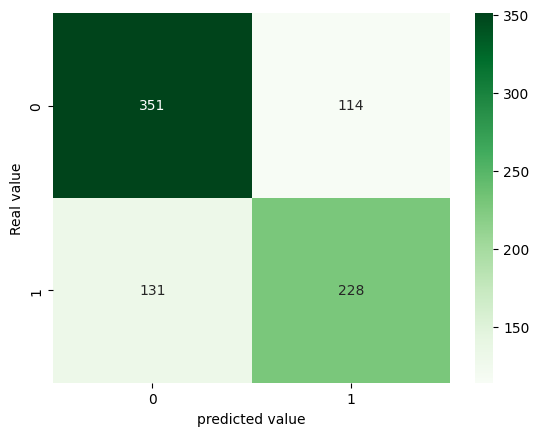

In [324]:
display_results(y_test, models['RNN']['y_pred'])

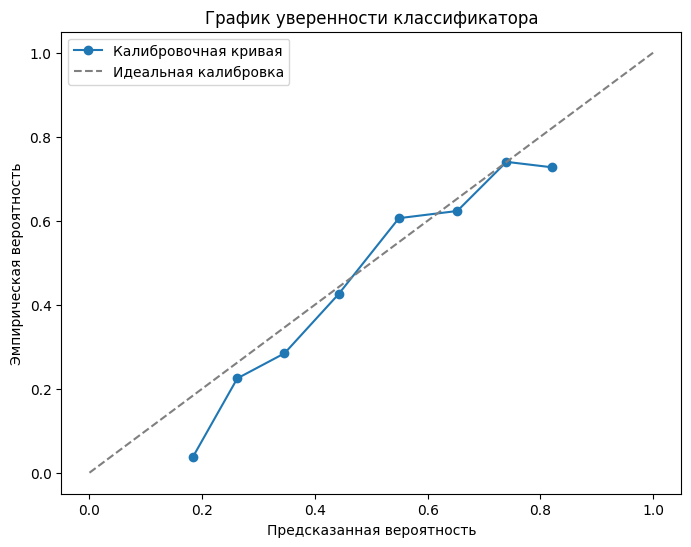

In [325]:
plot_confidence(y_test, models['RNN']['y_proba'])

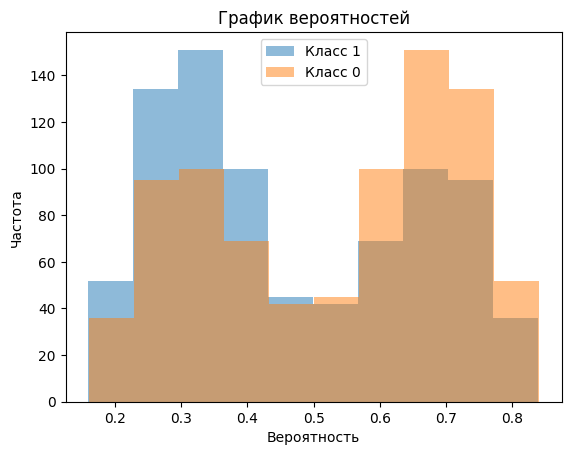

In [326]:
y_proba = models['RNN']['y_proba']
plt.hist(y_proba[:, 1], alpha=0.5, label='Класс 1')
plt.hist(y_proba[:, 0], alpha=0.5, label='Класс 0')
plt.xlabel('Вероятность')
plt.ylabel('Частота')
plt.title('График вероятностей')
plt.legend()
plt.show()

In [327]:
display_business_metrics(models['RNN']['y_proba'])

Результат выигрыша при использовании модели: 609041 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при случайном угадывании: 315269 рублей
------------------------------------------------------------
Относительный прирост выигрыша при использовании модели: 3.3 %


,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,PredWinner,PredError,GainModel,GainOdds,GainGuess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.641352,0.358648,0,0,0,1476,1476,-1000
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.718070,0.281930,0,0,0,1263,1263,-1000
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,0.819882,0.180118,0,0,0,1105,1105,-1000
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.613152,0.386848,1,0,1,-1000,-1000,-1000
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.729552,0.270448,0,0,0,1263,1263,-1000
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.648467,0.351533,1,0,1,-1000,-1000,2550
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.721964,0.278036,0,0,0,1512,1512,1512
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.661881,0.338119,0,0,0,1714,1714,1714
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.575276,0.424724,1,0,1,-1000,-1000,2050


Экспорт модели

In [46]:
# joblib.dump(models['RNN']['model'], 'models/rnn_model.joblib')

['models/rnn_model.joblib']

### Неудачные эксперименты
Модели, обученные на данных без Feature Engineering

### 5. RNN + fine-tune
Обучаем одну RNN-модель на всем датасете, чтобы получить общую модель, которая может захватить общую динамику боев.\
Затем, используем эту общую модель как базовую модель и делаем fine-tune для каждого бойца, используя его собственную последовательность боев

Загружаем данные с оригинальными признаками

In [328]:
# Данные для обучения берутся из аугментированного датасета, в котором бойцы поменяны местами
data_unfeatured_train = pd.read_csv('data_preprocessed/data_unfeatured_final_6596.csv', index_col='Unnamed: 0')
# Данные для тестирования берутся из датасета без аугментации
data_unfeatured_test = pd.read_csv('data_preprocessed/data_unfeatured_test_final_3298.csv', index_col='Unnamed: 0')

Создаем обучающую и тестовую выборки. метки классов при этом не меняются, поэтому y_train и y_test остаются теми же

In [329]:
# Данные для трейна берем из аугментированного датасета, выделяя из него три четверти
X_train_unfeatured = data_unfeatured_train.drop(columns=['WeightClass',
                                                         'Gender',
                                                         'NumberOfRounds'], axis=1).iloc[train_edge:, :]

# Данные для теста берем из не аугментированного датасета, выделяя из него одну четверть
X_test_unfeatured = data_unfeatured_test.drop(columns=['WeightClass',
                                                       'Gender',
                                                       'NumberOfRounds'], axis=1).iloc[:test_edge, :]

In [330]:
# Выберем все признаки, относящиеся к бойцу в красном
red_cols = [col for col in X_train_unfeatured.columns if col.find('Red') > -1] + ['RMatchWCRank']
# Выберем все признаки, относящиеся к бойцу в синем
blue_cols = [col for col in X_train_unfeatured.columns if col.find('Blue') > -1] + ['RMatchWCRank']

X_train_unfeatured = X_train_unfeatured[red_cols + blue_cols + ['Result']]
X_test_unfeatured = X_test_unfeatured[red_cols + blue_cols + ['Result']]

In [331]:
# Выберем все бои, где участовали бойцы минимум с 1 боем за плечами
fights_with_stats = X_train_unfeatured[((X_train_unfeatured['RedWins']\
                                             + X_train_unfeatured['RedLosses']) >= 1)\
                                                  & ((X_train_unfeatured['BlueWins']\
                                                       + X_train_unfeatured['BlueLosses']) >= 1)]

# Составим список всех бойцов
fighter_names = set(fights_with_stats.loc[(fights_with_stats['RedWins']\
                                            + fights_with_stats['RedLosses']) >= 5, 'RedFighter'].unique()) & \
                set(fights_with_stats.loc[(fights_with_stats['BlueWins']\
                                            + fights_with_stats['BlueLosses']) >= 5, 'BlueFighter'].unique())

print(f'Общее число бойцов, у которых более 5 боев: {len(fighter_names)}')

Общее число бойцов, у которых более 5 боев: 564


In [332]:
# Теперь составим для каждого бойца словарь, содержащий список из последних 5 боев с его участием
fighter_fights = {}
for fighter in fighter_names:
    fighter_fights[fighter] = fights_with_stats.loc[(fights_with_stats['RedFighter'] == fighter) | \
                             (fights_with_stats['BlueFighter'] == fighter)].head()

Посмотрим, что получилось на примере одного бойца

In [333]:
pd.DataFrame(fighter_fights['Brendan Allen'])

,RedFighter,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,RedWins,RedWinsBySubmission,RedCurrentWinStreak,RedLosses,...,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,BlueLongestWinStreak,BlueOdds,BlueWinsByDecision,BlueWinsByKO_TKO,BlueTimeSinceLastFight,RMatchWCRank,Result
1286,Brendan Allen,26,187.96,190.50,185,0.0,7,4,1,2,...,6.62,0.42,7,2,230.0,2,0,119,0.0,0
1286,Jacob Malkoun,26,175.26,185.42,185,0.0,2,0,2,1,...,1.74,0.47,17,4,-290.0,2,1,126,0.0,1
1479,Sam Alvey,35,187.96,190.50,185,1.0,10,1,0,11,...,1.74,0.47,15,4,-400.0,2,1,63,0.0,1
1479,Brendan Allen,26,187.96,190.50,185,0.0,6,3,0,2,...,0.06,0.14,49,4,300.0,4,5,161,0.0,0
1541,Brendan Allen,25,187.96,190.50,185,0.0,6,3,2,1,...,0.00,0.00,4,2,280.0,0,2,28,0.0,1


In [334]:
# Заново определим класс датасет для бойца
class FighterDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [338]:
# Для каждого бойца создаем отдельный датасет
fighter_datasets = {}
fighter_dataloaders = {}
for fighter, fights in fighter_fights.items():
    fighter_df = pd.DataFrame(fights)
    # Нормализуем данные и преобразуем их в тензоры    
    fighter_X = fighter_df.drop(['RedFighter', 'BlueFighter', 'Result'], axis=1)
    fighter_y = fighter_df['Result']
    scaler = StandardScaler()
    fighter_X = scaler.fit_transform(fighter_X)
    fighter_X = torch.tensor(fighter_X, dtype=torch.float32)
    fighter_y = torch.tensor(fighter_y.values, dtype=torch.long)
    # Создаем датасет для fine-tuning
    fighter_dataset = FighterDataset(fighter_X, fighter_y)
    # Создаем загрузчик данных для fine-tuning
    fighter_dataloader = DataLoader(fighter_dataset, batch_size=32, shuffle=True)
    # Сохраняем датасет и загрузчик в словарях
    fighter_datasets[fighter] = fighter_dataset
    fighter_dataloaders[fighter] = fighter_dataloader

Создание общей модели

In [339]:
X_train_unfeatured = X_train_unfeatured.drop(['RedFighter', 'BlueFighter', 'Result'], axis=1)
X_test_unfeatured = X_test_unfeatured.drop(['RedFighter', 'BlueFighter', 'Result'], axis=1)

In [340]:
scaler_unfeatured = StandardScaler()
X_train_unfeatured = scaler_unfeatured.fit_transform(X_train_unfeatured)
X_test_unfeatured = scaler_unfeatured.transform(X_test_unfeatured)

# Преобразование данных в тензоры PyTorch
X_tru = torch.FloatTensor(X_train_unfeatured)
y_tru = torch.FloatTensor(y_train.values)
X_teu = torch.FloatTensor(X_test_unfeatured)
y_teu = torch.FloatTensor(y_test.values)

# Создание датасета и загрузчика данных
train_dataset_unfeatured = TensorDataset(X_tru, y_tru)
test_dataset_unfeatured = TensorDataset(X_teu, y_teu)
train_dataloader_unfeatured = DataLoader(train_dataset_unfeatured, batch_size=32, shuffle=True)
test_dataloader_unfeatured = DataLoader(test_dataset_unfeatured, batch_size=32, shuffle=True)

In [341]:
# Определение модели
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return torch.sigmoid(out)

In [404]:
# Инициализация модели
model = RNNModel(input_dim=X_tru.shape[1], hidden_dim=128, output_dim=1)

# Обучение модели
criterion = nn.BCELoss()
optimizer = optim.Rprop(model.parameters(), lr=0.01)

# Обучение модели
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_dataloader_unfeatured:
        inputs = inputs.unsqueeze(1)  # Добавляем размерность последовательности
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.6699081063270569
Epoch 2, Loss: 0.52276211977005
Epoch 3, Loss: 0.563239336013794
Epoch 4, Loss: 0.5563240051269531
Epoch 5, Loss: 0.6717397570610046


In [405]:
# Оценка модели
model.eval()
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for inputs, labels in test_dataloader_unfeatured:
        inputs = inputs.unsqueeze(1)  # Добавляем размерность последовательности
        outputs = model(inputs)
        probabilities = outputs.squeeze()
        predictions = (probabilities > 0.5).float()
        
        all_predictions.extend(predictions.cpu().numpy())        
        all_probabilities.extend(probabilities.cpu().numpy())

probabilities = np.column_stack((
    np.array(all_probabilities), 
    1 - np.array(all_probabilities)
))

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       465
           1       0.43      0.46      0.44       359

    accuracy                           0.50       824
   macro avg       0.49      0.49      0.49       824
weighted avg       0.50      0.50      0.50       824



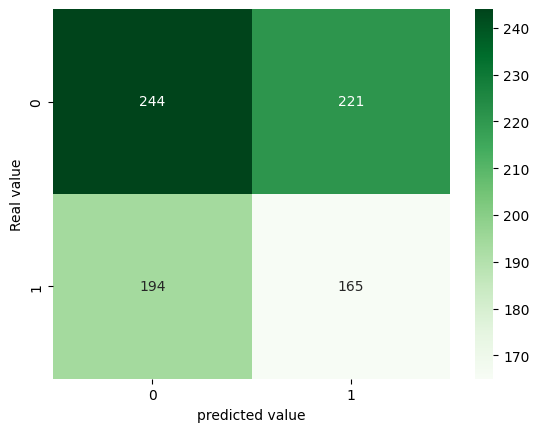

In [406]:
display_results(y_test, all_predictions)

In [407]:
display_business_metrics(probabilities)

Результат выигрыша при использовании модели: 358654 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при случайном угадывании: 332253 рублей
------------------------------------------------------------
Относительный прирост выигрыша при использовании модели: -39.1 %


,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,PredWinner,PredError,GainModel,GainOdds,GainGuess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.728091,0.271909,0,0,0,1476,1476,-1000
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.683385,0.316615,0,0,0,1263,1263,-1000
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,0.513633,0.486367,0,0,0,1105,1105,-1000
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.226589,0.773411,1,1,0,2100,-1000,-1000
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.659572,0.340428,0,0,0,1263,1263,-1000
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.521398,0.478602,1,0,1,-1000,-1000,-1000
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.357557,0.642443,0,1,1,-1000,1512,-1000
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.618425,0.381575,0,0,0,1714,1714,1714
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.379887,0.620113,1,1,0,2050,-1000,2050


Создание модели для каждого отлельного бойца

In [409]:
import copy

# Обучение fine-tuned моделей
fighter_models = {}
for fighter, fighter_dataloader in fighter_dataloaders.items():
    # Создаем копию основной модели
    fighter_model = copy.deepcopy(model)
    # Определяем функцию потерь и оптимизатор
    criterion = nn.BCELoss()
    optimizer = optim.Adam(fighter_model.parameters(), lr=0.001)
    # Обучаем fine-tuned модель
    for epoch in range(5):
        for x, y in fighter_dataloader:
            x = x.unsqueeze(1)  # добавляем временную размерность
            optimizer.zero_grad()
            outputs = fighter_model(x)
            loss = criterion(outputs.squeeze(), y.float())
            loss.backward()
            optimizer.step()
    # Сохраняем fine-tuned модель в словарь
    fighter_models[fighter] = fighter_model

In [410]:
# Объединение весов моделей
combined_model = model  # основная модель
beta = torch.tensor(0.1)  # экспоненциальный коэффициент
for fighter, fighter_model in fighter_models.items():
    for k in combined_model.state_dict():
        combined_model.state_dict()[k] = (1 / (1 + torch.exp(-beta))) * combined_model.state_dict()[k] + (torch.exp(-beta) / (1 + torch.exp(-beta))) * fighter_model.state_dict()[k]

In [411]:
# Оценка объединенной модели
combined_model.eval()
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for inputs, labels in test_dataloader_unfeatured:
        inputs = inputs.unsqueeze(1)  # Добавляем размерность последовательности
        outputs = combined_model(inputs)
        probabilities = outputs.squeeze()
        predictions = (probabilities > 0.5).float()
        
        all_predictions.extend(predictions.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

predictions = np.array(all_predictions)
probabilities = np.column_stack((
    np.array(all_probabilities), 
    1 - np.array(all_probabilities)
))

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.53      0.55       465
           1       0.44      0.47      0.45       359

    accuracy                           0.50       824
   macro avg       0.50      0.50      0.50       824
weighted avg       0.51      0.50      0.51       824



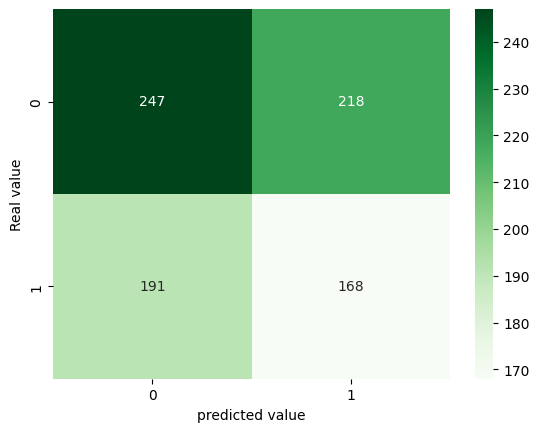

In [412]:
display_results(y_test, predictions)

In [413]:
display_business_metrics(probabilities)

Результат выигрыша при использовании модели: 346802 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при случайном угадывании: 299459 рублей
------------------------------------------------------------
Относительный прирост выигрыша при использовании модели: -41.2 %


,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,PredWinner,PredError,GainModel,GainOdds,GainGuess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.425525,0.574475,0,1,1,-1000,1476,-1000
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.563245,0.436755,0,0,0,1263,1263,-1000
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,0.252436,0.747564,0,1,1,-1000,1105,1105
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.748149,0.251851,1,0,1,-1000,-1000,2100
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.608323,0.391677,0,0,0,1263,1263,1263
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.598806,0.401194,1,0,1,-1000,-1000,-1000
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.229819,0.770181,0,1,1,-1000,1512,-1000
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.622673,0.377327,0,0,0,1714,1714,1714
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.344331,0.655669,1,1,0,2050,-1000,2050


### 6. Сиамская сеть
Сиамская нейронная сеть состоит из двух идентичных нейронных сетей, которые обрабатывают два входных данных параллельно.
 
Затем, выходы двух нейронных сетей объединяются и подаются на вход третьей нейронной сети, которая определяет сходство или различие между двумя входными данными

In [414]:
# Данные для обучения берутся из аугментированного датасета, в котором бойцы поменяны местами
data_unfeatured_train = pd.read_csv('data_preprocessed/data_unfeatured_final_6596.csv', index_col='Unnamed: 0')
# Данные для тестирования берутся из датасета без аугментации
data_unfeatured_test = pd.read_csv('data_preprocessed/data_unfeatured_test_final_3298.csv', index_col='Unnamed: 0')

# Данные для трейна берем из аугментированного датасета, выделяя из него три четверти
X_train_unfeatured = data_unfeatured_train.drop(columns=['RedFighter',
                                                         'BlueFighter',
                                                         'Result',
                                                         'WeightClass',
                                                         'Gender',
                                                         'NumberOfRounds'], axis=1).iloc[train_edge:, :]

# Данные для теста берем из не аугментированного датасета, выделяя из него одну четверть
X_test_unfeatured = data_unfeatured_test.drop(columns=['RedFighter',
                                                       'BlueFighter',
                                                       'Result',
                                                       'WeightClass',
                                                       'Gender',
                                                       'NumberOfRounds'], axis=1).iloc[:test_edge, :]

# Выберем все признаки, относящиеся к бойцу в красном
red_cols = [col for col in X_train_unfeatured.columns if col.find('Red') > -1] + ['RMatchWCRank']
# Выберем все признаки, относящиеся к бойцу в синем
blue_cols = [col for col in X_train_unfeatured.columns if col.find('Blue') > -1] + ['RMatchWCRank']

X_train_unfeatured = X_train_unfeatured[red_cols + blue_cols]
X_test_unfeatured = X_test_unfeatured[red_cols + blue_cols]

# Масштабируем данные
scaler_unfeatured = StandardScaler()
X_train_unfeatured = scaler_unfeatured.fit_transform(X_train_unfeatured)
X_test_unfeatured = scaler_unfeatured.transform(X_test_unfeatured)

# Преобразование данных в тензоры PyTorch
X_tru = torch.FloatTensor(X_train_unfeatured)
y_tru = torch.FloatTensor(y_train.values)
X_teu = torch.FloatTensor(X_test_unfeatured)
y_teu = torch.FloatTensor(y_test.values)

# Создание датасета и загрузчика данных
train_dataset_unfeatured = TensorDataset(X_tru, y_tru)
test_dataset_unfeatured = TensorDataset(X_teu, y_teu)
train_dataloader_unfeatured = DataLoader(train_dataset_unfeatured, batch_size=32, shuffle=True)
test_dataloader_unfeatured = DataLoader(test_dataset_unfeatured, batch_size=32, shuffle=True)

In [415]:
# Определение архитектуры сети
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim=22, embedding_dim=64):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward_one(self, x):
        return self.embedding_net(x)

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        out = torch.cat((out1, out2), 1)
        out = self.fc(out)
        return out

In [627]:
num_epochs = 10

# Инициализация модели, функции потерь и оптимизатора
model = SiameseNetwork()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Обучение модели
model.train()
for epoch in range(num_epochs):
    for i in range(0, len(X_tru), 32):
        batch_X = X_tru[i:i+batch_size]
        batch_y = y_tru[i:i+batch_size]
        
        x1 = batch_X[:, :22]
        x2 = batch_X[:, 22:]
        outputs = model(x1, x2)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.6761
Epoch [2/10], Loss: 0.6201
Epoch [3/10], Loss: 0.6003
Epoch [4/10], Loss: 0.5930
Epoch [5/10], Loss: 0.5860
Epoch [6/10], Loss: 0.5802
Epoch [7/10], Loss: 0.5749
Epoch [8/10], Loss: 0.5696
Epoch [9/10], Loss: 0.5640
Epoch [10/10], Loss: 0.5582


In [628]:
# Оценка модели
model.eval()
all_predictions = []
all_targets = []
all_probabilities = []

with torch.no_grad():
    for i in range(0, len(X_teu), batch_size):
        batch_X = X_teu[i:i+batch_size]
        batch_y = y_teu[i:i+batch_size]
        
        x1 = batch_X[:, :22]
        x2 = batch_X[:, 22:]
        outputs = model(x1, x2)
        probabilities = torch.sigmoid(outputs).squeeze()
        
        # Вероятности для обоих классов
        probs_class_1 = 1 - probabilities
        probs_class_2 = probabilities
        probs_both_classes = torch.stack((probs_class_1, probs_class_2), dim=1)
        
        predictions = (probabilities > 0.5).float()
        
        all_predictions.extend(predictions.numpy())
        all_targets.extend(batch_y.numpy())
        all_probabilities.append(probs_both_classes.numpy())

probabilities = np.vstack(all_probabilities)

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       465
           1       0.66      0.62      0.64       359

    accuracy                           0.70       824
   macro avg       0.69      0.69      0.69       824
weighted avg       0.69      0.70      0.70       824



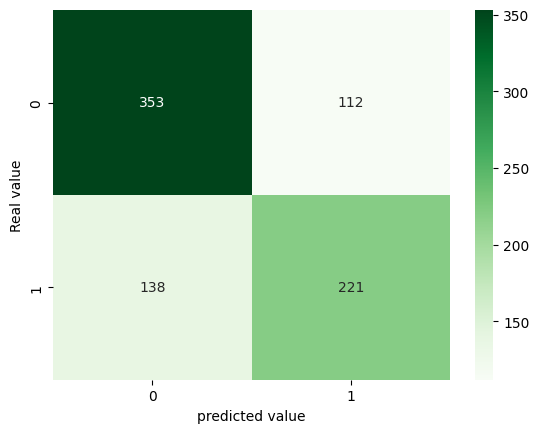

In [629]:
display_results(y_test, all_predictions)

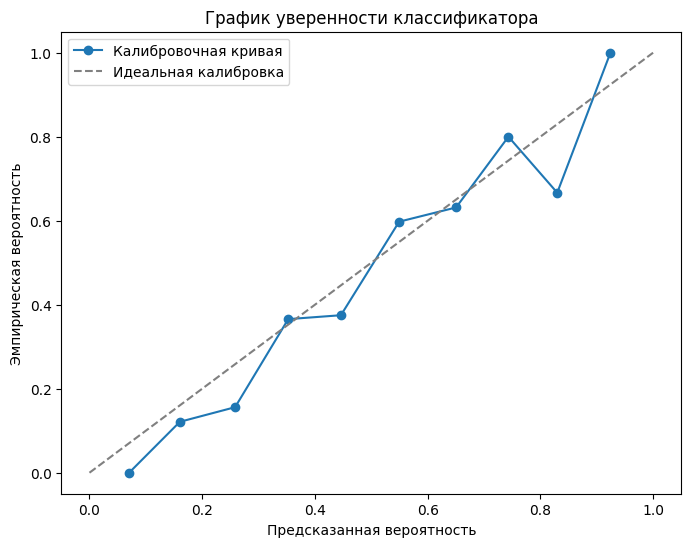

In [630]:
plot_confidence(y_test, probabilities, model)


In [631]:
display_business_metrics(probabilities)

Результат выигрыша при использовании модели: 597594 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при случайном угадывании: 351376 рублей
------------------------------------------------------------
Относительный прирост выигрыша при использовании модели: 1.4 %


,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,PredWinner,PredError,GainModel,GainOdds,GainGuess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.651564,0.348436,0,0,0,1476,1476,1476
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.663016,0.336984,0,0,0,1263,1263,1263
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,0.909952,0.090048,0,0,0,1105,1105,1105
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.580745,0.419255,1,0,1,-1000,-1000,-1000
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.615654,0.384346,0,0,0,1263,1263,-1000
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.618860,0.381140,1,0,1,-1000,-1000,-1000
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.573495,0.426505,0,0,0,1512,1512,-1000
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.576958,0.423042,0,0,0,1714,1714,1714
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.648781,0.351219,1,0,1,-1000,-1000,2050


### 7. Эмбеддинг-нейросеть + Предсказательная нейросеть
Эмбеддинг-нейросеть принимает на вход характеристики одного бойца и выдает эмбеддинг, который представляет бойца в виде вектора. Эта нейросеть будет использоваться для обоих бойцов, красного и синего.

Предсказательная нейросеть будет принимать на вход два эмбеддинга, полученные из эмбеддинг-нейросети, и выдавать предсказание о том, кто победит

In [632]:
class EmbeddingNetwork(nn.Module):
    def __init__(self, input_dim=22, embedding_dim=64):
        super(EmbeddingNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, embedding_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class PredictionNetwork(nn.Module):
    def __init__(self, embedding_dim=64):
        super(PredictionNetwork, self).__init__()
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [633]:
class UFCPredictor(nn.Module):
    def __init__(self, input_dim=22, embedding_dim=64):
        super(UFCPredictor, self).__init__()
        self.embedding_net = EmbeddingNetwork(input_dim, embedding_dim)
        self.prediction_net = PredictionNetwork(embedding_dim)

    def forward(self, x1, x2):
        embed1 = self.embedding_net(x1)
        embed2 = self.embedding_net(x2)
        output = self.prediction_net(embed1, embed2)
        return output

In [668]:
# Инициализация модели, функции потерь и оптимизатора
model = UFCPredictor()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение
num_epochs = 10
for epoch in range(num_epochs):
    for batch_X, batch_y in train_dataloader_unfeatured:
        # Разделение входных данных на пары бойцов
        x1 = batch_X[:, :22]
        x2 = batch_X[:, 22:]

        # Прямой проход
        outputs = model(x1, x2)
        loss = criterion(outputs, batch_y.unsqueeze(1))

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.5638
Epoch [2/10], Loss: 0.6758
Epoch [3/10], Loss: 0.6153
Epoch [4/10], Loss: 0.6276
Epoch [5/10], Loss: 0.6081
Epoch [6/10], Loss: 0.4029
Epoch [7/10], Loss: 0.3821
Epoch [8/10], Loss: 0.4318
Epoch [9/10], Loss: 0.6115
Epoch [10/10], Loss: 0.3850


In [669]:
model.eval()  # Переключаем модель в режим оценки
all_predictions = []
all_probabilities = []

with torch.no_grad():  # Отключаем вычисление градиентов
    for batch_X, batch_y in test_dataloader_unfeatured:        
        
        # Разделение входных данных на пары бойцов
        x1 = batch_X[:, :22]
        x2 = batch_X[:, 22:]
        
        outputs = model(x1, x2)
        probabilities = torch.sigmoid(outputs).squeeze()
            
        # Вероятности для обоих классов
        probs_class_1 = 1 - probabilities
        probs_class_2 = probabilities
        probs_both_classes = torch.stack((probs_class_1, probs_class_2), dim=1)
        
        predictions = (probabilities > 0.5).float()
        
        all_predictions.extend(predictions.numpy())
        all_targets.extend(batch_y.numpy())
        all_probabilities.append(probs_both_classes.numpy())

probabilities = np.vstack(all_probabilities)

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.54      0.56       465
           1       0.44      0.48      0.46       359

    accuracy                           0.51       824
   macro avg       0.51      0.51      0.51       824
weighted avg       0.52      0.51      0.51       824



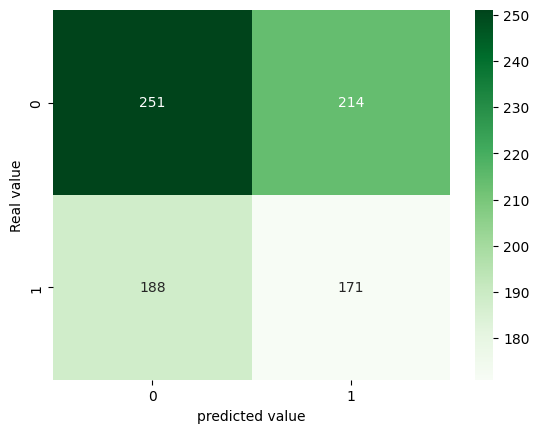

In [670]:
display_results(y_test, all_predictions)

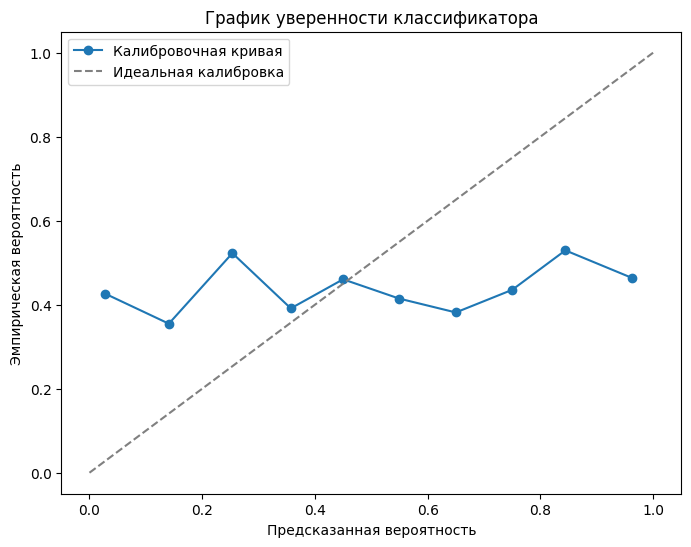

In [671]:
plot_confidence(y_test, probabilities, model)

In [672]:
display_business_metrics(probabilities)

Результат выигрыша при использовании модели: 378695 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при случайном угадывании: 316999 рублей
------------------------------------------------------------
Относительный прирост выигрыша при использовании модели: -35.7 %


,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,PredWinner,PredError,GainModel,GainOdds,GainGuess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.201154,0.798846,0,1,1,-1000,1476,-1000
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.325563,0.674437,0,1,1,-1000,1263,1263
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,0.996032,0.003968,0,0,0,1105,1105,-1000
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.865435,0.134565,1,0,1,-1000,-1000,-1000
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.008847,0.991153,0,1,1,-1000,1263,1263
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.277745,0.722255,1,1,0,2550,-1000,2550
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.897721,0.102279,0,0,0,1512,1512,-1000
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.434487,0.565513,0,1,1,-1000,1714,-1000
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.156464,0.843536,1,1,0,2050,-1000,2050
